# libraries

In [2]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

## OPTIONS DATA

In [5]:
def updateData():
    ''' This function is used to get the raw-data in JSON format from NSE NIFTY50 Options using it's API and storing it '''
    
    url='https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'
    headers={
        'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
        "accept-encoding" : "gzip, deflate, br",
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8'
    }
    session=requests.Session()
    request=session.get(url,headers=headers)
    cookies=dict(request.cookies)
    response=session.get(url,headers=headers,cookies=cookies).json()
    rawdata=pd.DataFrame(response)
    # The rawdata would have the present day's record as well as future dateabss
    rawop=pd.DataFrame(rawdata['filtered']['data']).fillna(0)
    nifty50cur=rawdata['records']['underlyingValue']
    # Taking only the present day's data, and returning it
    return rawop,nifty50cur

## option data extraction

In [6]:
def dataframe(rawop):
    ''' This function is used to convert the Raw-JSON data into a structured data-frame'''
    data=[]
    for i in range(0,len(rawop)):
        calloi=callcoi=putoi=putcoi=calliv=putiv=cltp=pltp=0
        stp=rawop['strikePrice'][i]
        exp=rawop["expiryDate"][i]
        if(rawop['CE'][i]==0):
            calloi=callcoi=0
        else:
            calloi=rawop['CE'][i]['openInterest']
            callcoi=rawop['CE'][i]['changeinOpenInterest']            
            cltp=rawop['CE'][i]['lastPrice']
            calliv=rawop['CE'][i]['impliedVolatility']
        if(rawop['PE'][i]==0):
            putoi=putcoi=0
        else:
            putoi=rawop['PE'][i]['openInterest']
            putcoi=rawop['PE'][i]['changeinOpenInterest']            
            pltp=rawop['PE'][i]['lastPrice']
            putiv=rawop['PE'][i]['impliedVolatility']
        opdata = {
            'EXP': exp,
            'STP': stp,
            'CALL OI': calloi, 'CALL COI':callcoi, 'CALL LTP':cltp, 'CALL IV':calliv,
            'PUT OI': putoi, 'PUT COI':putcoi, 'PUT LTP':pltp, 'PUT IV':putiv,
        }              
        data.append(opdata)
    optionchain=pd.DataFrame(data)
    return optionchain

In [7]:
optionchain = dataframe(updateData()[0])
nifty50cur = (updateData()[1])

In [8]:
optionchain.columns

Index(['EXP', 'STP', 'CALL OI', 'CALL COI', 'CALL LTP', 'CALL IV', 'PUT OI',
       'PUT COI', 'PUT LTP', 'PUT IV'],
      dtype='object')

In [8]:
nifty50cur

18203.4

In [33]:
def appendpcrOI(optionchain):
    ''' This function gives us the ratio for PUT OI and CALL OI.
        Significance is to get what is the people's perception of a particular strike price'''
    pcr=[]
    optionchain=optionchain.T
    for i in range(0,optionchain.shape[1]):
        if(optionchain.loc['CALL OI'][i]!=0):
            pcr.append(optionchain.loc['PUT OI'][i]/optionchain.loc['CALL OI'][i])
        else:
            pcr.append(0)
    optionchain.loc['PCR OI']=pcr
    optionchain=optionchain.T
    return optionchain

In [13]:
def appendpcrCOI(optionchain):
    '''This function provides us the ratio of the change in PUT OI and the change in the CALL OI.
       This function tells us the dynamic change in the people's percetion'''
    pcr=[]
    optionchain=optionchain.T
    for i in range(0,optionchain.shape[1]):
        if(optionchain.loc['CALL COI'][i]!=0):
            pcr.append(optionchain.loc['PUT COI'][i]/optionchain.loc['CALL COI'][i])
        else:
            pcr.append(0)
    optionchain.loc['PCR COI']=pcr
    optionchain=optionchain.T
    return optionchain

In [34]:
def STP_range(optionchain, percent, niftyprice):
    ''' Gives the STP range for percent above and below niftyprice'''
    low = niftyprice*(100-percent)/100
    high = niftyprice*(100+percent)/100
    min_idx = optionchain['STP'].sub(low).abs().idxmin()
    max_idx = optionchain['STP'].sub(high).abs().idxmin()
    range1=[min_idx,max_idx]
    return (range1)

In [35]:
optionchain.nlargest(5, ['CALL OI'])['CALL OI'].to_numpy()

array([159514, 134427, 115674, 102847,  99464])

In [36]:
def plotmaxOI(optionchain):
    tot_sum_CALL_OI = optionchain['CALL OI'].sum()
    tot_sum_PUT_OI = optionchain['PUT OI'].sum()
    CALL_OI_max_5 = optionchain.nlargest(5, ['CALL OI'])['CALL OI'].to_numpy()
    CALL_OI_max_5_normalzed = CALL_OI_max_5/tot_sum_CALL_OI*100
    print(CALL_OI_max_5_normalzed)
    PUT_OI_max_5 = optionchain.nlargest(5, ['PUT OI'])['PUT OI'].to_numpy()
    PUT_OI_max_5_normalzed = PUT_OI_max_5/tot_sum_PUT_OI*100
    plt.pie(CALL_OI_max_5_normalzed,labels=CALL_OI_max_5)
    plt.show()

[10.47182768  8.82490803  7.5938049   6.75173377  6.52964547]


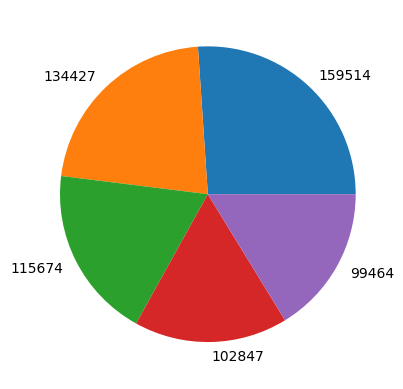

In [37]:
plotmaxOI(optionchain)

In [43]:
def plotOI(optionchain,STPrange):
    '''Plot OI'''
    [min,max]=STPrange
    X = optionchain['STP'][min:max]
    YC = optionchain['CALL OI'][min:max]
    YP = optionchain['PUT OI'][min:max]
    Xmod = [optionchain['STP'][min] , optionchain['STP'][(min+max)//2] ,optionchain['STP'][max]] 
    X_axis = np.arange(len(X))
    X_axismod = [0,len(X)//2,len(X)]
    
    plt.bar(X_axis - 0.2, YC, 0.4, label = 'CALL')
    plt.bar(X_axis + 0.2, YP, 0.4, label = 'PUT')

    plt.xticks(X_axismod, Xmod)

    plt.xlabel("STP")
    plt.ylabel("OI")
    plt.title("CALL | PUT OI BAR GRAPH")
    plt.legend()
    plt.show()

    

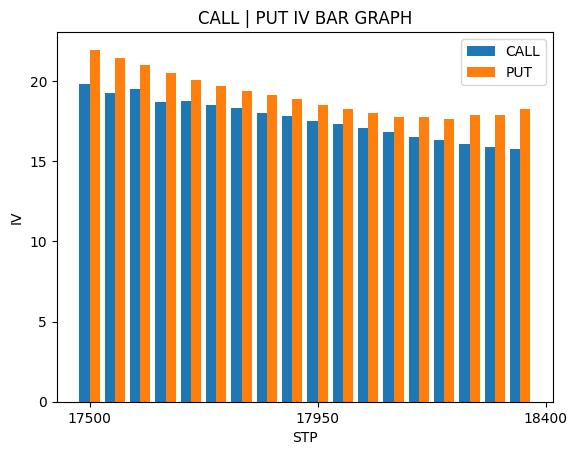

In [52]:
plotIV(optionchain,STP_range(optionchain,2.5,nifty50cur))

In [47]:
def plotCOI(optionchain,STPrange):
    [min,max]=STPrange
    X = optionchain['STP'][min:max]
    YC = optionchain['CALL COI'][min:max]
    YP = optionchain['PUT COI'][min:max]
    Xmod = [optionchain['STP'][min] , optionchain['STP'][(min+max)//2] ,optionchain['STP'][max]] 
    X_axis = np.arange(len(X))
    X_axismod = [0,len(X)//2,len(X)]

    plt.bar(X_axis - 0.2, YC, 0.4, label = 'CALL')
    plt.bar(X_axis + 0.2, YP, 0.4, label = 'PUT')

    plt.xticks(X_axismod, Xmod)
    plt.xlabel("STP")
    plt.ylabel("COI")
    plt.title("CALL | PUT COI BAR GRAPH")
    plt.legend()
    plt.show()

In [72]:
def totPCR(optionchain):
    totCall=sum(np.array(optionchain['CALL OI']))
    totPut=sum(np.array(optionchain['PUT OI']))
    return [(totPut/totCall),totPut,totCall]

In [51]:
def plotIV(optionchain,STPrange):
    [min,max]=STPrange
    X = optionchain['STP'][min:max]
    YC = optionchain['CALL IV'][min:max]
    YP = optionchain['PUT IV'][min:max]
    Xmod = [optionchain['STP'][min] , optionchain['STP'][(min+max)//2] ,optionchain['STP'][max]] 
    X_axis = np.arange(len(X))
    X_axismod = [0,len(X)//2,len(X)]

    plt.bar(X_axis - 0.2, YC, 0.4, label = 'CALL')
    plt.bar(X_axis + 0.2, YP, 0.4, label = 'PUT')

    plt.xticks(X_axismod, Xmod)
    plt.xlabel("STP")
    plt.ylabel("IV")
    plt.title("CALL | PUT IV BAR GRAPH")
    plt.legend()
    plt.show()
    

In [74]:
def plotIVtime(optionchain):
  
    x = np.arange(0,len(CalloldIVATM)) #it is time
    y = CalloldIVATM #CalloldIVATM is a global variable
    # first plot with X and Y data
    plt.plot(x, y)
    y1 = PutoldIVATM

    # second plot with x1 and y1 data
    plt.plot(x, y1, '-.')

    plt.xlabel("time")
    plt.ylabel("IV ATM")
    plt.title('IV changing with time')
    plt.show()
    

In [2]:
def storeIV(optionchain,CalloldIVATM,PutoldIVATM,nifty50cur):
    optionchain=optionchain.T
    i = STPATM(optionchain,nifty50cur)
    CalloldIVATM.append(optionchain.loc['CALL IV'][i])
    PutoldIVATM.append(optionchain.loc['PUT IV'][i])
    return ([CalloldIVATM,PutoldIVATM])  #add update iv atm in main function
    
    

In [7]:
def STPATM(optionchain,nifty50cur):
    for i in range(0,optionchain.shape[0]):
        if(optionchain.iloc[i][1]<nifty50cur and optionchain.iloc[i+1][1]>nifty50cur):
            if(abs(optionchain.iloc[i][1]-nifty50cur)>abs(optionchain.iloc[i+1][1]-nifty50cur)):
                return i+1
            else:
                return i

In [9]:
optionchain.iloc[STPATM(optionchain,nifty50cur)][1]

17900

In [23]:
import nsepy
